# Titanic Dataset Machine Learning Model

## Wprowadzenie

Poniższe opracowanie wykonano w oparciu o jeden z najpopularniejszych zbiorów danych dostępnych na platformie _kaggle.com_. Dotyczy on katastrofy Titanica i zawiera informacje nt. poszczególnych pasażerów, tj. m.in. tego czy przeżyli katastrofę, jaką klasą podróżowali czy skąd wyruszyli. Na jego podstawie przygotowano model uczenia maszynowego, który dokonuje klasyfikacji pasażerów na dwie grupy:

- pasażer przeżył katastrofę (1)
- pasażer nie przeżył katastrofy (0)

Jest to przykład uczenia nadzorowanego (ang. supervised learning). Pierwotny zbiór danych jest podzielony na dwa podzbiory: 
- treningowy - użyjemy go do wytrenowania oraz walidacji modelu
- testowy - użyjemy go do ostatecznej oceny jakości naszego modelu

Kolejne kolumny zbioru danych:

    Survived  -  Survival (0 = No, 1 = Yes)
    Pclass  -  Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
    Name - name, surename, title
    Sex  -  gender
    Age  -  Age in years
    SibSp  -  Number of siblings / spouses aboard the Titanic
    Parch  -  Number of parents / children aboard the Titanic
    Ticket  -  Ticket number
    Fare  -  Passenger fare (price)
    Cabin  -  Cabin number
    Embarked  -  Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)    

## Konfiguracja środowiska

In [1]:
# Moduły podstawowe
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ustawienia wyświetlania
pd.set_option('display.max_columns', 50)
pd.set_option('precision', 2)
%matplotlib inline

# Stałe dla lokalizacji na dysku
DIR = '.'

## Data exploration
#### Ładowanie danych do DataFrame:

Póki co będziemy pracować jedynie na zbiorze treningowym (train.csv) i użyjemy go do wytrenowania modelu oraz jego walidacji. Następnie dostroimy parametry modelu w celu poprawy jego jakości i przeprowadzimy ostateczne sprawdzenie jakości za pomocą zbioru testowego (test.csv).

In [3]:
# zbiór treningowy
X_full = pd.read_csv('./Titanic_dataset/train.csv', index_col='PassengerId')

# zbiór testowy
X_test_full = pd.read_csv('./Titanic_dataset/train.csv', index_col='PassengerId')

#### Rzut oka na strukturę danych:

In [4]:
X_full.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [5]:
print(X_full.shape)
X_full.info()

(891, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Zbiór, którego użyjemy to trenowania modelu składa się z 891 obserwacji, co oznacza, że jest on bardzo mały jak na standardy uczenia maszynowego. Wyraźnie widać, że atrybut _Cabin_ zawiera jedynie 204 wartości niezerowe, co oznacza, że cecha ta nie została zdefiniowana dla blisko 80% obserwacji. Braki danych zawierają ponadto atrybuty _Age_ i _Embarked_.

W związku z powyższym od razu zdecydowano się usunąć kolumnę _Cabin_.

In [6]:
# Usunięcie kolumny "Cabin" ze względu na przeważającą ilość braków danych
X_full.drop(columns=['Cabin'], inplace=True)

In [7]:
X_full.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


#### Podział danych na numeryczne i kategoryczne:

In [8]:
data_num = X_full[['Age', 'SibSp', 'Parch', 'Fare']]
data_cat = X_full[['Survived', 'Pclass', 'Sex', 'Ticket', 'Embarked']]

#### Wizualizacja danych
#### - Dane numeryczne:

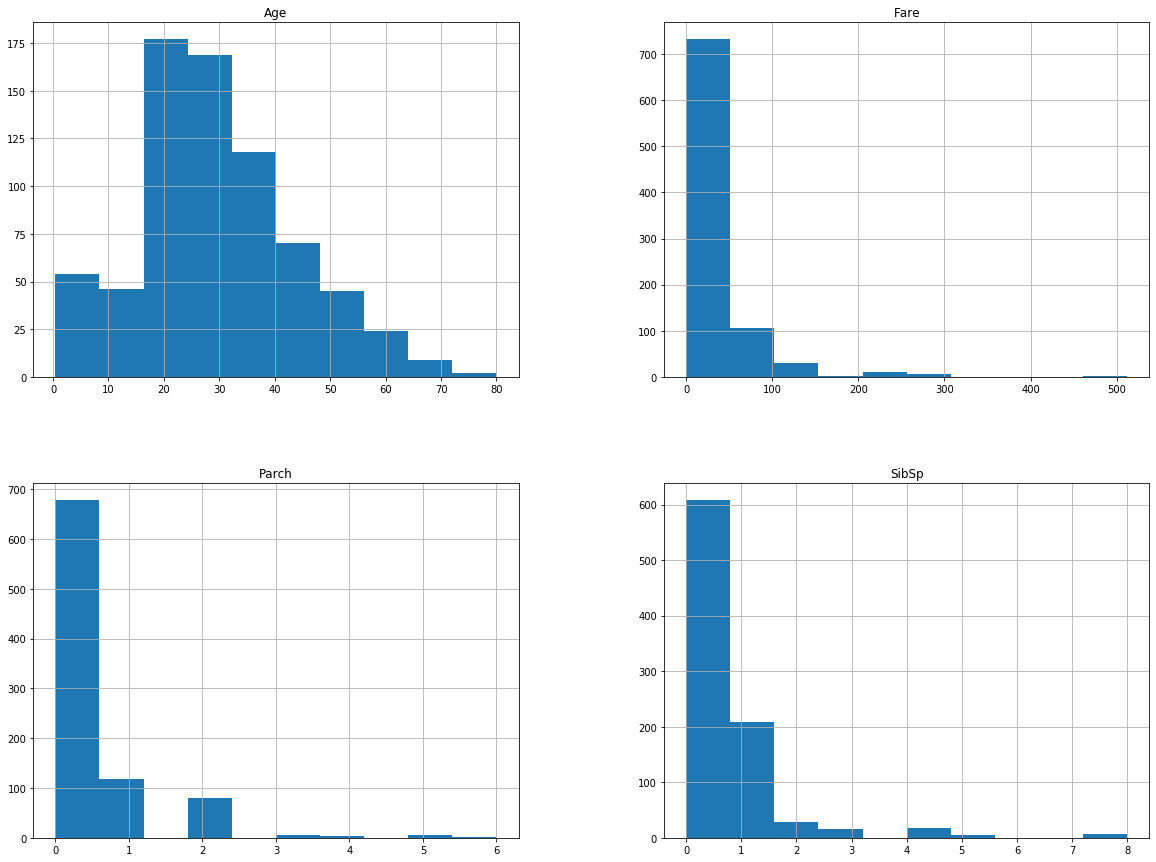

In [9]:
# histogramy (rozkład ilościowy) danych numerycznych
data_num.hist(figsize=(20,15))
plt.show()

In [10]:
# korelacje pomiędzy zmiennymi
correlation = data_num.corr()
correlation

,Age,SibSp,Parch,Fare
Age,1.00,-0.31,-0.19,0.10
SibSp,-0.31,1.00,0.41,0.16
Parch,-0.19,0.41,1.00,0.22
Fare,0.10,0.16,0.22,1.00


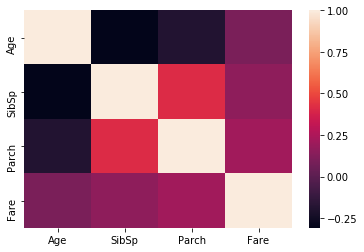

In [11]:
sns.heatmap(correlation)

In [19]:
# Średnia zmiennych numerycznych w zależności od wskaźnika przeżywalności
pd.pivot_table(X_full, index='Survived', values=data_num.columns)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.63,22.12,0.33,0.55
1,28.34,48.40,0.46,0.47


#### - Dane kategoryczne:

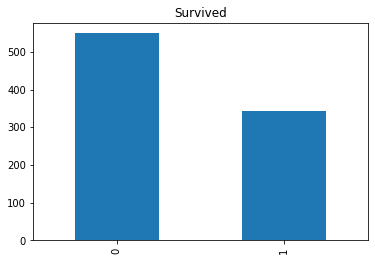

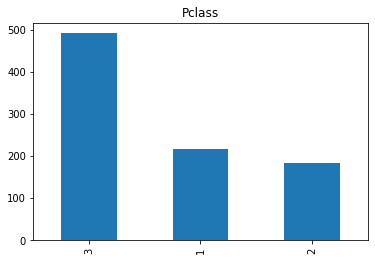

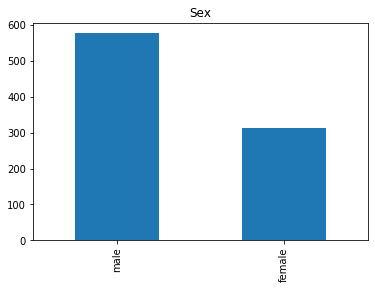

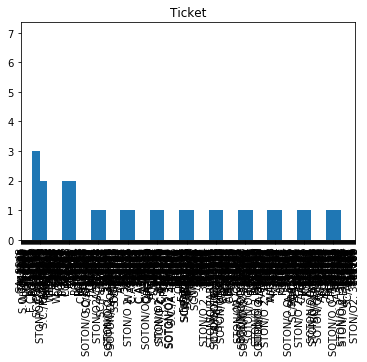

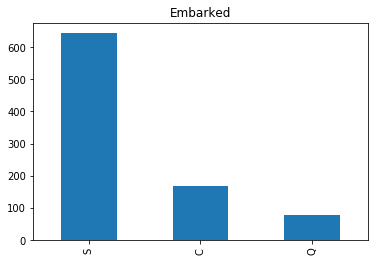

In [12]:
# Podział ilościowy dla każdej z wartości danych kategorycznych
for c in data_cat.columns:
    data_cat[c].value_counts().plot(kind="bar")
    plt.title(c)
    plt.show()

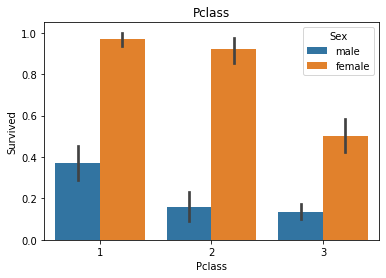

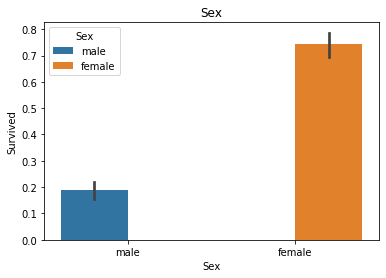

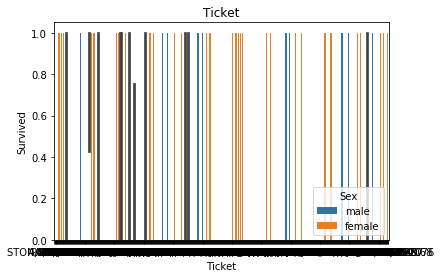

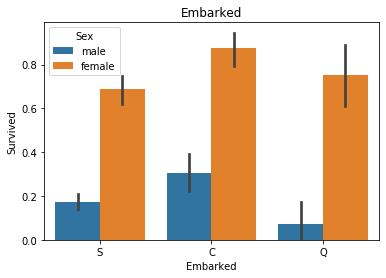

In [13]:
# Przeżywalność pasażerów w zależności wartości zmiennych kategorycznych z podziałem na płeć
for c in data_cat.columns[1:]:
    sns.barplot(x=c, y='Survived', hue='Sex', data=data_cat)
    plt.title(c)
    plt.show()

## Feature engineering

Kolumna "Ticket": 

- powywalaj kropki, ukośniki, spacje, białe znaki
- sprawdź czy jest numer, litery+numer, litery

In [20]:
X_full['Ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [32]:
X_full['Ticket_let'] = X_full['Ticket'].apply(lambda x: 1 if x.isalpha() else 0)
X_full['Ticket_num'] = X_full['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
X_full['Ticket_let_num'] = X_full['Ticket'].apply(lambda x: 1 if x.isalnum() else 0)

Kolumna 'Name':

- wyciągnij "tytuł" i zrób "count encoding"